In [1]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

### Load data

In [2]:
# Apply necessary image transfromations here 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [3]:
train_data_dir = '../dataset/train' # put path of training dataset
val_data_dir = '../dataset/val' # put path of validation dataset
test_data_dir = '../dataset/test' # put path of test dataset

trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=32,
                                         shuffle=False, num_workers=2)

testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [4]:
#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

Load the model

In [5]:
from classifiers import Net4

model_dir = "../models"
model_fname = "Net4_30.pth"
model_path = model_dir + '/' + model_fname

if torch.cuda.is_available():
    checkpoint = torch.load(f=model_path)
else:
    checkpoint = torch.load(f=model_path, map_location=torch.device('cpu'))

net = Net4()
if torch.cuda.is_available():
    net = net.cuda()

net.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch'] + 1

net.eval()

Net4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block5): Sequential(
    (0): Conv2d(128, 

In [6]:
classwise_test(testloader, net)

100%|██████████| 79/79 [00:10<00:00,  7.89it/s]Accuracy of  aeroplane : 96 %
Accuracy of        cat : 65 %
Accuracy of       deer : 88 %
Accuracy of        dog : 70 %
Accuracy of       frog : 84 %



# 2.1 - Occlusion

In [7]:

# Finds and returns probablity heatmap for grayscaling heatmap
def occlusion(net, img, label, kernel_size):
    
    width, height = img.shape[-1], img.shape[-2]
    
    heatmap = torch.zeros((height-kernel_size+1, width-kernel_size+1))
    
    for i in tqdm(range(height-kernel_size+1)):
        bottom = i+kernel_size
        for j in range(width-kernel_size+1):
            right = j+kernel_size
            
            #grayscale img tensor in required window
            img_clone = img.clone().detach()
            
            img_clone[:, :, i:bottom, j:right] = 0.5

            #run inference on modified image
            output = net(img_clone)

            #convert loss to probability
            output = F.softmax(output, dim=1)

            heatmap[i, j] = output[0][label]
    
    return heatmap

In [8]:
def imshow(img, title, ax):
     
    npimg = img.numpy()
  
    #plot the image as numpy array
    ax.axis("off")
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title)

Sample 10 random images from test set

In [14]:
subset_indices = np.random.randint(2500,size=10) 
subset = torch.utils.data.Subset(testset, subset_indices)

evalloader = torch.utils.data.DataLoader(subset, batch_size=1, shuffle=False)
evaliter = iter(evalloader)

id_class, class_id = find_classes(test_data_dir)
kernel_size = 10
len(subset)

10

100%|██████████| 55/55 [00:34<00:00,  1.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 55/55 [00:36<00:00,  1.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 55/55 [00:32<00:00,  1.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 55/55 [00:40<00:00,  1.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 55/55 [00:34<00:00,  1.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 55/55 [00:35<00:00,  1.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 55/55 [00:35<00:00,  1.55it/s]
Clip

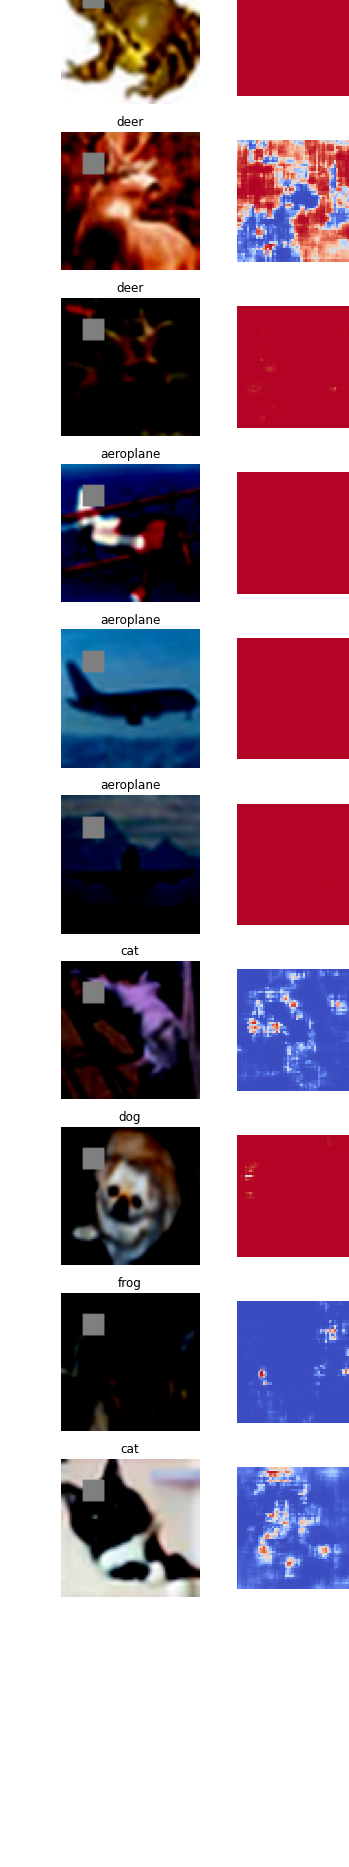

In [15]:
fig, axes = plt.subplots(nrows = len(subset), ncols=2, figsize=(6,3*len(subset)))
idx=0
with torch.no_grad():   
    for data in evalloader:
        image, label = evaliter.next()
        heatmap = occlusion(net, image, label, kernel_size)
        sns.heatmap(heatmap, vmin=0, vmax=1,xticklabels=False,yticklabels=False,
                    ax=axes[idx,1], square=True, cmap='coolwarm')
        img_clone = image.detach().clone()
        img_clone[:,:,10:(10+kernel_size),10:(10+kernel_size)] = 0.5
        imshow(img_clone[0],id_class[label],axes[idx,0])
        idx+=1
plt.suptitle('Occluded images with repective heatmaps')
plt.savefig('../images/Occlusion_heatmaps.png')

# 2.2 Filter Analysis

Load model

In [153]:
model_dir = "../models"
model_fname = "Net4_30.pth"
model_path = model_dir + '/' + model_fname
from classifiers import Net4
if torch.cuda.is_available():
    checkpoint = torch.load(f=model_path)
else:
    checkpoint = torch.load(f=model_path, map_location=torch.device('cpu'))

net = Net4()

if torch.cuda.is_available():
    net = net.cuda()

net.load_state_dict(checkpoint['model_state_dict'])

epoch = checkpoint['epoch'] + 1

net.eval()

Net4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block5): Sequential(
    (0): Conv2d(128, 

In [154]:
evalloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=2, shuffle=False)

In [173]:
evalloader.dataset[0][1]

0

Define a forward hook and register hooks for all required intermediate layers

In [155]:
activation = {}
def get_activation(name):
    def hook_fn(model, inp, out):
        activation[name] = out.detach()
    return hook_fn

net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))
net.conv_block3[0].register_forward_hook(get_activation('conv3'))
net.conv_block4[0].register_forward_hook(get_activation('conv4'))
net.conv_block5[0].register_forward_hook(get_activation('conv5'))

Compute and store activations for the filter in the specified layer

In [156]:
def find_filtermaps(net, testloader, filter_id, layer_name):
    act = None
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            
            output = net(images)
            act_b = activation[layer_name][:,filter_id]
            if act == None:
                act = act_b
            else:
                act = torch.cat((act, act_b),dim=0)
    return act

In [216]:
def imshow(img, ax, title=None):
     
    npimg = img.numpy()
  
    #plot the image as numpy array
    ax.axis("off")
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if title!=None:
        ax.set_title(title)

In [223]:
id_to_class, classes_to_id = find_classes(test_data_dir)

### 2.2.1 Filter mapping
Filter id for ever layer:  
Layer 1 - Filters 2 and 13  
Layer 2 - Filters 11 and 23  
Layer 3 - Filters 9 and 49  
Layer 4 - Filters 54 and 98  
Layer 5 - Filters 171 and 5

100%|██████████| 79/79 [00:05<00:00, 14.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 79/79 [00:05<00:00, 13.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to t

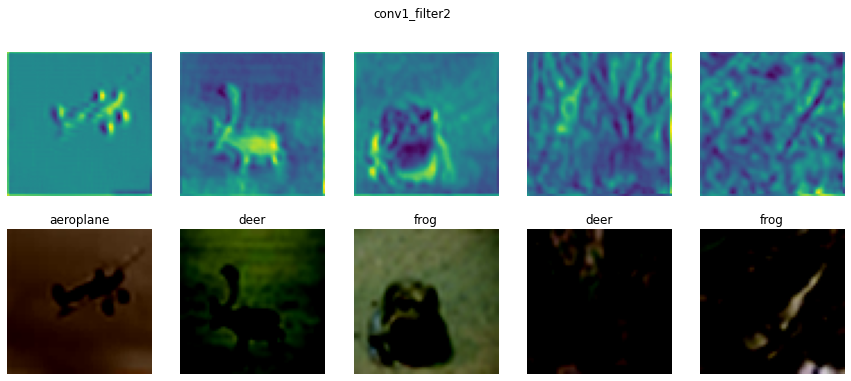

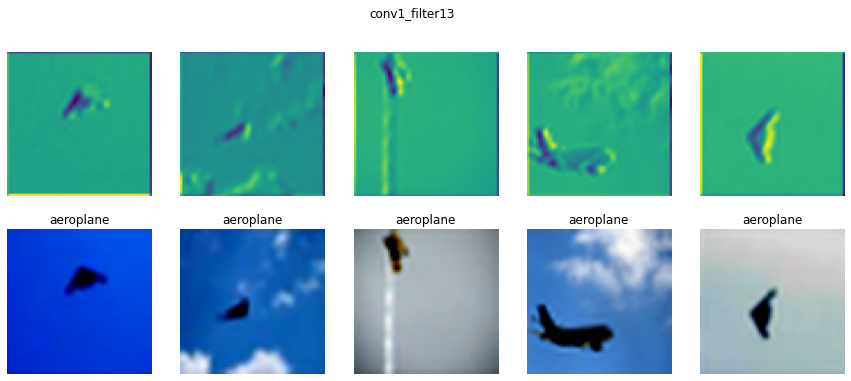

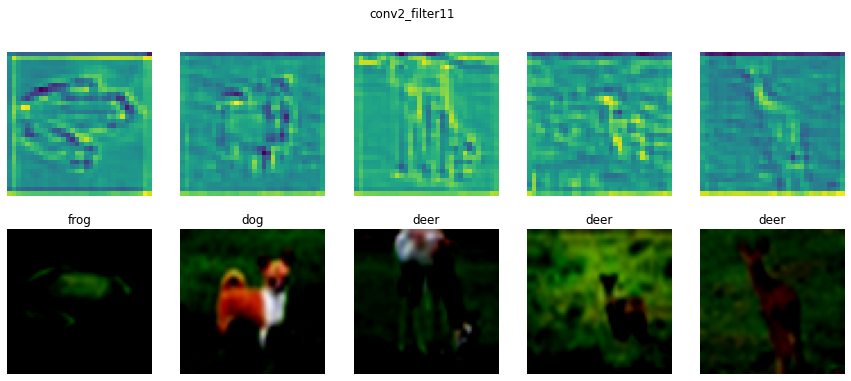

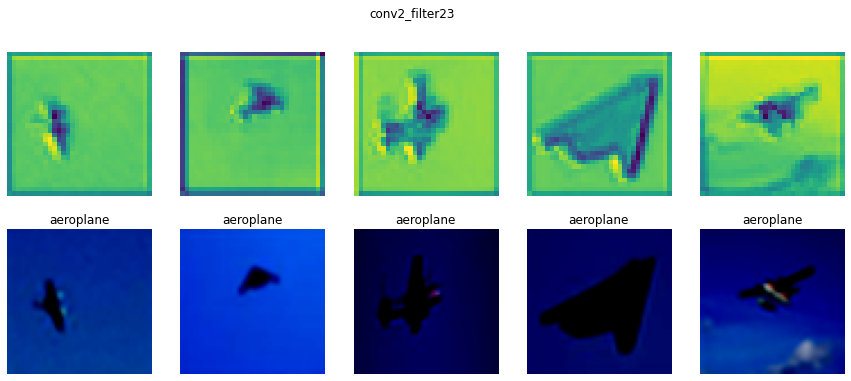

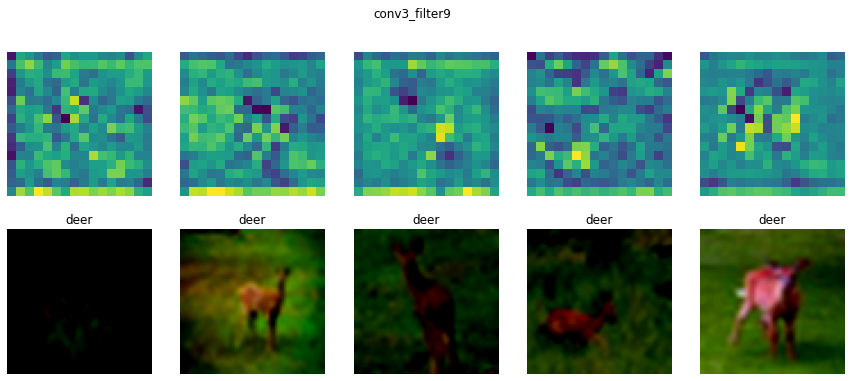

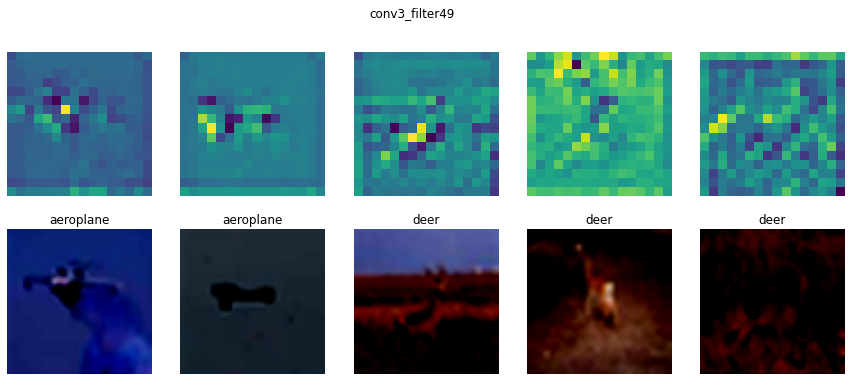

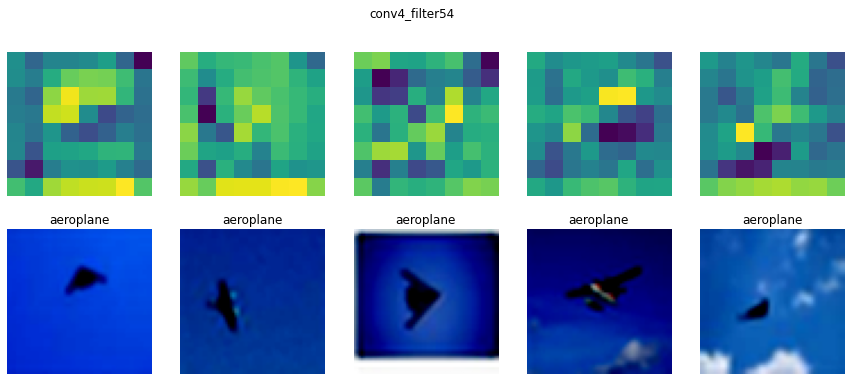

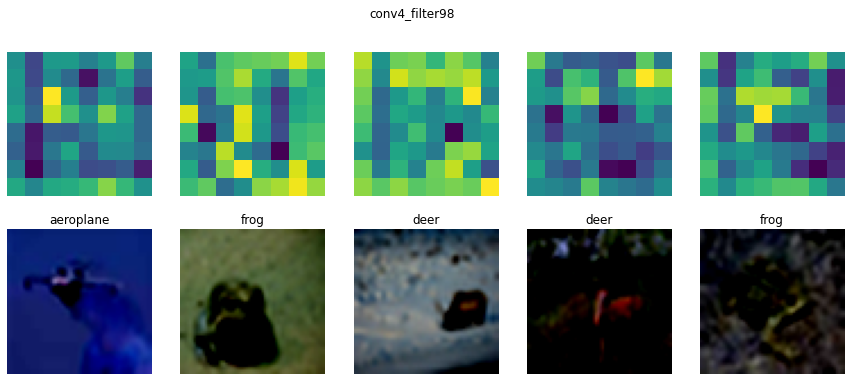

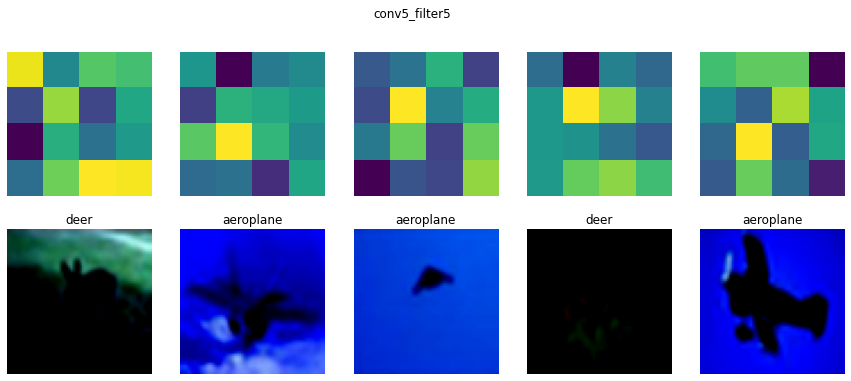

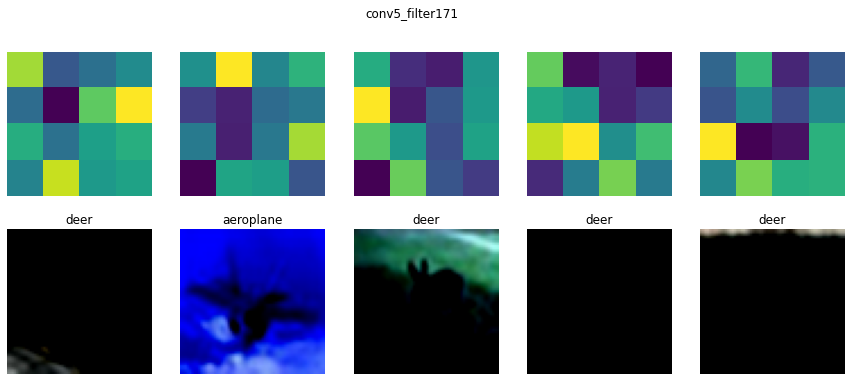

In [239]:
layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']
filter_idx = {'conv1' : [2,13], 'conv2' : [11,23], 'conv3' : [9,49], 'conv4' : [54,98], 'conv5':[5,171]}

for l in layer_names:
    for f in filter_idx[l]:
        act = find_filtermaps(net, evalloader, f, l)
        act_idx = torch.argsort(torch.Tensor([act[i].norm() for i in range(act.shape[0])]),descending=False)
        fig,axes = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
        for i in range(5):
            imshow((act[act_idx[i]])[None,:,:],axes[0,i])
            img, label = evalloader.dataset[act_idx[i]]
            imshow(img,axes[1,i],id_to_class[label])
        plot_name = l + '_filter' + str(f)
        plt.suptitle(plot_name)
        plt.savefig('../images/Filter_'+plot_name+'.png')

### 2.2.2 Filter Switchoff

In [250]:
def find_accuracymap(net, testloader):
    c = None
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            outputs = net(images)
            _,predicted = torch.max(outputs,1)
            c_batch = (predicted==labels).squeeze().int()
            if c==None:
                c=c_batch
            else:
                c=torch.cat((c,c_batch),dim=0)
    return c

In [254]:
acc_on = find_accuracymap(net,evalloader)

100%|██████████| 79/79 [00:05<00:00, 15.10it/s]


Switch off weights in filters

In [262]:
net.conv1.weight[2]=0
net.conv1.weight[13]=0

net.conv2.weight[11]=0
net.conv2.weight[23]=0

net.conv_block3[0].weight[9]=0
net.conv_block3[0].weight[49]=0

net.conv_block4[0].weight[54]=0
net.conv_block4[0].weight[98]=0

net.conv_block5[0].weight[5]=0
net.conv_block5[0].weight[171]=0

Find accuracy with filters off

In [263]:
acc_off = find_accuracymap(net,evalloader)

100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


Evaluate error

In [279]:
cnt=0
img_idx = []
for i in range(len(evalloader.dataset)):
    if acc_on[i]==1 and acc_off[i]==0:
        cnt+=1
        img_idx.append(i)

## Classwise count
n_class=5
classwise_error = list(0. for i in range(n_class))
for idx in img_idx:
    classwise_error[evalloader.dataset[idx][1]]+=1
    
for i in range(n_class):
    print("%15s : %d images"%(id_to_class[i],classwise_error[i]))
    

      aeroplane : 7 images
            cat : 31 images
           deer : 18 images
            dog : 50 images
           frog : 12 images


In [277]:
evalloader.dataset[2499][1]

4